In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mglearn

from sklearn.model_selection import cross_val_score, KFold, LeaveOneOut, ShuffleSplit, GroupKFold, train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve

from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
from sklearn.datasets import load_digits

digits = load_digits()
iris = load_iris()

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# 交差検証
交差検証(cross-validation)はデータの分割を何度も繰り返して行い，複数のモデルを訓練する．  
訓練セットとテストセットの分割を何度もするイメージに近い．  

### k-fold cross-validation_
最もよく使われる交差検証はk-fold cross-validation．  
5-fold cross-validationはデータを5つに分割し1をテストセット，他を訓練セットして使用．   
これを1から5まで5回繰り返す．  

データセットの偏りに精度が依存する場合の性能の違いがわかる．  
分割数を増やすと，毎回の訓練データに使用できるデータ量が増える．  
ただし，交差検証はk倍時間がかかる．

また，データセットの正解ラベルの偏りを無くすために，stratified k-fold cross-validationがある．

In [7]:
# irisデータセットのk-fold cross-validation

logreg = LogisticRegression(max_iter=1000)

scores = cross_val_score(logreg, iris.data, iris.target, cv=5)
print("Cross-validation scores: {}".format(scores))

print("Average cross-validation score: {:.2f}".format(scores.mean()))

Cross-validation scores: [0.96666667 1.         0.93333333 0.96666667 1.        ]
Average cross-validation score: 0.97


In [8]:
# より詳細な制御

logreg = LogisticRegression(max_iter=1000)

kfold = KFold(n_splits=3, shuffle=True, random_state=0)
print("Cross-validation scores:\n{}".format(
    cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[0.98 0.96 0.96]


### leave-one-out
データセット中の1サンプルだけをテストセットとして検証する．  
時間がかかるが，小さいデータセットに関しては，よりよい推定が可能になる．

In [11]:
loo = LeaveOneOut()
scores = cross_val_score(logreg, iris.data, iris.target, cv=loo)
print("Number of cv iterations: ", len(scores))
print("Mean accuracy: {:.2f}".format(scores.mean()))

Number of cv iterations:  150
Mean accuracy: 0.97


### シャッフル分割交差検証
テストセットと訓練セットの数を任意に設定する交差検証  
テストセットを何度も同じデータを使うようなこともあり得るようにシャッフルする．  

In [14]:
shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
scores = cross_val_score(logreg, iris.data, iris.target, cv=shuffle_split)
print("Cross-validation scores:\n{}".format(scores))

Cross-validation scores:
[0.97333333 0.94666667 0.97333333 0.97333333 0.94666667 0.93333333
 0.97333333 0.97333333 0.92       1.        ]


### GroupeKFold
どのグループにデータが属しているかで分割する．  
これはいわゆる被験者間の交差検証などで使用される．　　

In [19]:
X, y = make_blobs(n_samples=12, random_state=0)
print(X)

groups = [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3]
scores = cross_val_score(logreg, X, y, groups=groups, cv=GroupKFold(n_splits=3))
print("Cross-validation scores:\n{}".format(scores))

[[ 3.54934659  0.6925054 ]
 [ 1.9263585   4.15243012]
 [ 0.0058752   4.38724103]
 [ 1.12031365  5.75806083]
 [ 1.7373078   4.42546234]
 [ 2.36833522  0.04356792]
 [-0.49772229  1.55128226]
 [-1.4811455   2.73069841]
 [ 0.87305123  4.71438583]
 [-0.66246781  2.17571724]
 [ 0.74285061  1.46351659]
 [ 2.49913075  1.23133799]]
Cross-validation scores:
[0.75       0.6        0.66666667]


# グリッドサーチ
ハイパーパラメタのすべての組合せを試す方法．  
例えば，SVCにはカーネルのバンド幅を表すgammmaと正則化パラメタであるCが存在する．  
Cとgammaに対して6つずつの組合せ計36の組合せを考える．  

単純なグリッドリサーチは2つのパラメータをforループで実装する．  
ただし，学習セットとテストセットを用意しテストセットが良くなるようにパラメタを選んだ場合は間違いであることがある．  
そのパラメタが新しいデータに最も良い性能であるとはいえず，テストセットに対してだけいいパラメタだといえる．  
つまりパラメタのチューニング用のデータセットが必要であるということ．  

### 3分割のグリッドサーチ
この問題に解決するために3分割したデータセットを用いる．  
- training setをモデルの学習
- validation setをパラメタの選択
- test setを評価



In [25]:
# 3分割のグリッドサーチ

X_trainval, X_test, y_trainval, y_test = train_test_split(
    iris.data, iris.target, random_state=0)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, random_state=1)
print("Size of training set: {}   size of validation set: {}   size of test set:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:

        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)

        score = svm.score(X_valid, y_valid)

        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Size of training set: 84   size of validation set: 28   size of test set: 38

Best score on validation set: 0.96
Best parameters:  {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


### 交差検証を用いたグリッドサーチ

In [32]:
# 交差検証をする

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:

        svm = SVC(gamma=gamma, C=C)
        
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        
        score = np.mean(scores)
        
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

SVC(C=10, gamma=0.1)

#### 便利なGridSearchCV
今までの学習器と同じようにfitでき，自動で交差検証をしてくれる．  
交差検証の結果も格納されている．

In [34]:
# GridSearchCVを使う方法

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(SVC(), param_grid, cv=5,
                          return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=0)

grid_search.fit(X_train, y_train)
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Test set score: 0.97


In [36]:
# 結果を見る方法

results = pd.DataFrame(grid_search.cv_results_)
display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.002529,0.000923,0.000945,0.000158,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.347826,0.347826,0.363636,...,0.366403,0.022485,22,0.370787,0.370787,0.366667,0.366667,0.355556,0.366092,0.005581
1,0.001224,0.000405,0.000199,0.000397,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.347826,0.347826,0.363636,...,0.366403,0.022485,22,0.370787,0.370787,0.366667,0.366667,0.355556,0.366092,0.005581
2,0.000770,0.000388,0.000597,0.000488,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.347826,0.347826,0.363636,...,0.366403,0.022485,22,0.370787,0.370787,0.366667,0.366667,0.355556,0.366092,0.005581
3,0.001152,0.000222,0.000000,0.000000,0.001,1,"{'C': 0.001, 'gamma': 1}",0.347826,0.347826,0.363636,...,0.366403,0.022485,22,0.370787,0.370787,0.366667,0.366667,0.355556,0.366092,0.005581
4,0.000995,0.000014,0.000217,0.000434,0.001,10,"{'C': 0.001, 'gamma': 10}",0.347826,0.347826,0.363636,...,0.366403,0.022485,22,0.370787,0.370787,0.366667,0.366667,0.355556,0.366092,0.005581


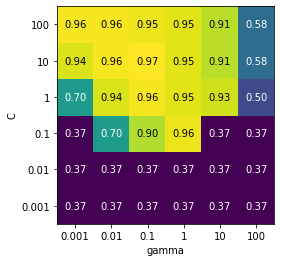

In [39]:
# ヒートマップで可視化

scores = np.array(results.mean_test_score).reshape(6, 6)
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'],
                      ylabel='C', yticklabels=param_grid['C'], cmap="viridis")

In [41]:
# 相互に関係しあうグリッドでないパラメタをサーチする方法

param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

grid_search = GridSearchCV(SVC(), param_grid, cv=5,
                          return_train_score=True)
grid_search.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation score: 0.97


### ネストした交差検証
訓練とテストを交差検証し，その訓練の中でもグリッドリサーチで交差検証する．

In [42]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5),
                         iris.data, iris.target, cv=5)
print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.96666667 1.         0.96666667 0.96666667 1.        ]
Mean cross-validation score:  0.9800000000000001


# 評価基準とスコア
精度やR2で評価してきたが，他の基準が良いかもしれない．  
がんの患者を当てるのには，精度よりもfalse negativeを可能な限り避けるべきである．  

また偏ったデータセットの問題もある．  
片方のデータが多く，もう片方のデータが少ない場合をそのまま学習すると，データが多いほうと答えるだけで精度が上がってしまう．  
これでは，精度は評価基準として不適切である．

### 混合行列とF値

そこでよく使われるのが，混同行列(confusion matrix)である．  
また基準としては，適合率(precision)，再現率(recall)，f値(f1 score)が使われる．

### 適合率-再現率カーブ
再現率を高めたい場合，全てを陽性にすれば100%になる．  
そのようなモデルは意味がないので，適合率をどこまであげたほうがいいかが問題になる．  

そこで適合率-再現率カーブから組合せを見て決定する．  
また，複数の学習器でこのカーブを表示して，どれを使用するかを考えるなどもする．

カーブの下領域を積分した値の平均適合率(average precision)を算出し，特定のスレッショルドに依存しないカーブ自身の評価をすることもできる．

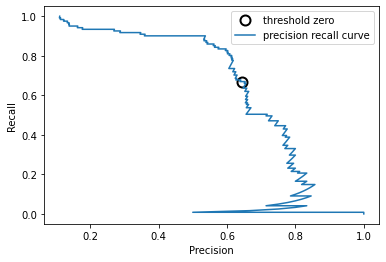

In [6]:

# データの準備
X, y = make_blobs(n_samples=(400, 50), cluster_std=[7.0, 2],
                  random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

precision, recall, thresholds = precision_recall_curve(
    y_test, svc.decision_function(X_test))


# 学習
X, y = make_blobs(n_samples=(4000, 500), cluster_std=[7.0, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_train, y_train)


precision, recall, thresholds = precision_recall_curve(
    y_test, svc.decision_function(X_test))

close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)

plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

### ROC
ROCカーブは，偽陽性率(FSR)と真陽性率(TPR)に対してプロットする．  
ただし真陽性率は再現率の別名．

ROCのカーブの下の領域面積を用いてAUCを算出し，学習器を比較できる．  
AUCは0から1でランダムな予測は必ず0.5になる．  
偏ったクラス分類の問題を評価する基準は精度よりもAUCが良い．  


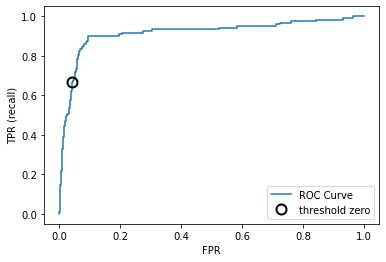

In [9]:
fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

# 多クラス分類
まず多クラスでは，混同行列を作成するのが普通．  
また，偏ったデータセットに対する多クラス分類問題では，多クラス版のF値で評価する．  
- macro平均のF値
- weighted平均のF値
- micro平均のF値

In [16]:
# データの準備
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, random_state=0)
lr = LogisticRegression().fit(X_train, y_train)
pred = lr.predict(X_test)

# F値
print("Micro average f1 score: {:.3f}".format(
    f1_score(y_test, pred, average="micro")))
print("Macro average f1 score: {:.3f}".format(
    f1_score(y_test, pred, average="macro")))

Micro average f1 score: 0.953
Macro average f1 score: 0.954


C:\Users\S2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 回帰の基準
回帰は基本的にR2を用いれば，評価できる．  
ビジネス決定を行う場合はMAEはMSEを用いるかもしれない．  

# まとめ
交差検証とグリッドリサーチの理解は大事

よく使われる評価基準は
- accuracy
- AUC
- average precision
- f1
- f1 macro
- f1 micro
- f1 weighted
- r2
- mse
- mae